# NY Taxi fair Prediction using Fast.ai library

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [67]:
from fastai.structured import * 
from fastai.column_data import *

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

###### The fulldataset has 55 million records. Train a small sample to tune the nural network and then use the full dataset for training

In [3]:
PATH='data/taxi/'
DATASET_SIZE = 45000
SUBMISSION_NAME=f'{PATH}tmp/submission17.csv'

In [4]:
datatypes = {'key': 'str', 
              'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

In [5]:
#df_train =  pd.read_csv(f'{PATH}train.csv', parse_dates=["pickup_datetime"],nrows=DATASET_SIZE, dtype=datatypes, usecols=[0,1,2,3,4,5,6])
df_train =  pd.read_csv(f'{PATH}train.csv')

In [6]:
#df_test = pd.read_csv(f'{PATH}test.csv', parse_dates=["pickup_datetime"], dtype=datatypes,usecols=[0,1,2,3,4,5])
df_test = pd.read_csv(f'{PATH}test.csv', parse_dates=["pickup_datetime"])

In [7]:
from IPython.display import HTML, display

In [8]:
display(df_train.head())

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [9]:
df_train.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [10]:
#df_train.describe()

###### Data clean, process and feature engineering 

In [11]:
def clean(df):
    # Delimiter lats and lons to NY only
    df=df[(-75 <= df['pickup_longitude']) & (df['pickup_longitude'] <= -73)]
    df=df[(-75 <= df['dropoff_longitude']) & (df['dropoff_longitude'] <= -73)]
    df=df[(39 <= df['pickup_latitude']) & (df['pickup_latitude'] <= 42)]
    df=df[(39 <= df['dropoff_latitude']) & (df['dropoff_latitude'] <= 42)]
    # Remove possible outliers
    df=df[(0 < df['fare_amount']) & (df['fare_amount'] <= 250)]
    # Remove inconsistent values
    df=df[(df['dropoff_longitude'] != df['pickup_longitude'])]
    df=df[(df['dropoff_latitude'] != df['pickup_latitude'])]
    
    return df

def late_night (row):
    if (row['hour'] <= 6) or (row['hour'] >= 20):
        return 1
    else:
        return 0

def night (row):
    if ((row['hour'] <= 20) and (row['hour'] >= 16)) and (row['weekday'] < 5):
        return 1
    else:
        return 0
        
def process(df):
   # df['pickup_datetime'] =  pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S %Z')
    df['pickup_datetime_dt'] = pd.to_datetime(df['pickup_datetime'])
   # df['pickup_datetime_dt'] = df['pickup_datetime'].apply(lambda d: df.pickup_datetime.strptime(d, '%Y-%m-%d %H:%M:%S UTC'))
    df['hour'] = df['pickup_datetime_dt'].apply(lambda x: x.hour)
    df['weekday'] = df['pickup_datetime_dt'].apply(lambda x: x.weekday())
    df['night'] = df.apply (lambda x: night(x), axis=1)
    df['late_night'] = df.apply (lambda x: late_night(x), axis=1)
        
    return df    

def add_engineered(df):
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
    weekday = df['weekday']
    hour = df['hour']
    
    latdiff = (lat1 - lat2)
    londiff = (lon1 - lon2)
    euclidean = (latdiff ** 2 + londiff ** 2) ** 0.5
    manhattan = np.abs(lat2 - lat1) + np.abs(lon2 - lon1)
    ploc = lat1 * lon1
    dloc = lat2 * lon2

    # Add new features
    df['latdiff'] = latdiff
    df['londiff'] = londiff
    df['euclidean'] = euclidean
    df['manhattan'] = manhattan
    df['ploc'] = ploc
    df['dloc'] = dloc    
       
    return df


###### Below code is required for executing the python functions in parallel

In [12]:
import numpy as np
from multiprocessing import cpu_count
from multiprocessing import Pool
 
#cores = cpu_count() #Number of CPU cores on your system
cores = 24
partitions = cores #Define as many partitions as you want
 
def parallelize(data, func):
    data_split = np.array_split(data, partitions)
    pool = Pool(cores)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data

In [13]:
df_train2 = parallelize(df_train, clean);

In [14]:
df_train3 = parallelize(df_train2, process);

In [15]:
df_train4 = parallelize(df_train3, add_engineered);

In [16]:
df_test2 = process(df_test)

In [17]:
df_test3 = add_engineered(df_test2)

In [18]:
train = df_train4
test = df_test3

In [19]:
add_datepart(train, "pickup_datetime_dt", drop=False)
add_datepart(test, "pickup_datetime_dt", drop=False)

In [20]:
display(df_train4.head())

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_dt,hour,...,pickup_datetime_dtDay,pickup_datetime_dtDayofweek,pickup_datetime_dtDayofyear,pickup_datetime_dtIs_month_end,pickup_datetime_dtIs_month_start,pickup_datetime_dtIs_quarter_end,pickup_datetime_dtIs_quarter_start,pickup_datetime_dtIs_year_end,pickup_datetime_dtIs_year_start,pickup_datetime_dtElapsed
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15 17:26:21,17,...,15,0,166,False,False,False,False,False,False,1245086781
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05 16:52:16,16,...,5,1,5,False,False,False,False,False,False,1262710336
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18 00:35:00,0,...,18,3,230,False,False,False,False,False,False,1313627700
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21 04:30:42,4,...,21,5,112,False,False,False,False,False,False,1334982642
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09 07:51:00,7,...,9,1,68,False,False,False,False,False,False,1268121060


In [21]:
train.dtypes

key                                           object
fare_amount                                  float64
pickup_datetime                               object
pickup_longitude                             float64
pickup_latitude                              float64
dropoff_longitude                            float64
dropoff_latitude                             float64
passenger_count                                int64
pickup_datetime_dt                    datetime64[ns]
hour                                           int64
weekday                                        int64
night                                          int64
late_night                                     int64
latdiff                                      float64
londiff                                      float64
euclidean                                    float64
manhattan                                    float64
ploc                                         float64
dloc                                         f

In [22]:
train = train.drop(['pickup_datetime_dt','pickup_datetime_dtElapsed','pickup_datetime'],axis=1)
test = test.drop(['pickup_datetime_dt','pickup_datetime_dtElapsed','pickup_datetime'],axis=1)

In [23]:
display(train.head())

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,night,...,pickup_datetime_dtWeek,pickup_datetime_dtDay,pickup_datetime_dtDayofweek,pickup_datetime_dtDayofyear,pickup_datetime_dtIs_month_end,pickup_datetime_dtIs_month_start,pickup_datetime_dtIs_quarter_end,pickup_datetime_dtIs_quarter_start,pickup_datetime_dtIs_year_end,pickup_datetime_dtIs_year_start
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1,17,0,1,...,25,15,0,166,False,False,False,False,False,False
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1,16,1,1,...,1,5,1,5,False,False,False,False,False,False
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0,3,0,...,33,18,3,230,False,False,False,False,False,False
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1,4,5,0,...,16,21,5,112,False,False,False,False,False,False
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1,7,1,0,...,10,9,1,68,False,False,False,False,False,False


In [24]:
display(test.head())

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,night,late_night,...,pickup_datetime_dtWeek,pickup_datetime_dtDay,pickup_datetime_dtDayofweek,pickup_datetime_dtDayofyear,pickup_datetime_dtIs_month_end,pickup_datetime_dtIs_month_start,pickup_datetime_dtIs_quarter_end,pickup_datetime_dtIs_quarter_start,pickup_datetime_dtIs_year_end,pickup_datetime_dtIs_year_start
0,2015-01-27 13:08:24.0000002,-73.973320,40.763805,-73.981430,40.743835,1,13,1,0,0,...,5,27,1,27,False,False,False,False,False,False
1,2015-01-27 13:08:24.0000003,-73.986862,40.719383,-73.998886,40.739201,1,13,1,0,0,...,5,27,1,27,False,False,False,False,False,False
2,2011-10-08 11:53:44.0000002,-73.982524,40.751260,-73.979654,40.746139,1,11,5,0,0,...,40,8,5,281,False,False,False,False,False,False
3,2012-12-01 21:12:12.0000002,-73.981160,40.767807,-73.990448,40.751635,1,21,5,0,1,...,48,1,5,336,False,True,False,False,False,False
4,2012-12-01 21:12:12.0000003,-73.966046,40.789775,-73.988565,40.744427,1,21,5,0,1,...,48,1,5,336,False,True,False,False,False,False


In [25]:
train.dtypes

key                                    object
fare_amount                           float64
pickup_longitude                      float64
pickup_latitude                       float64
dropoff_longitude                     float64
dropoff_latitude                      float64
passenger_count                         int64
hour                                    int64
weekday                                 int64
night                                   int64
late_night                              int64
latdiff                               float64
londiff                               float64
euclidean                             float64
manhattan                             float64
ploc                                  float64
dloc                                  float64
pickup_datetime_dtYear                  int64
pickup_datetime_dtMonth                 int64
pickup_datetime_dtWeek                  int64
pickup_datetime_dtDay                   int64
pickup_datetime_dtDayofweek       

In [26]:
cat_vars = ['hour','weekday','night','late_night','pickup_datetime_dtYear','pickup_datetime_dtMonth','pickup_datetime_dtWeek'
            ,'pickup_datetime_dtDay','pickup_datetime_dtDayofweek','pickup_datetime_dtDayofyear','pickup_datetime_dtIs_month_end'
            ,'pickup_datetime_dtIs_month_start','pickup_datetime_dtIs_quarter_end','pickup_datetime_dtIs_quarter_start'
            ,'pickup_datetime_dtIs_year_end','pickup_datetime_dtIs_year_start']

contin_vars = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude','latdiff','londiff','euclidean','manhattan','ploc','dloc'] 

In [27]:
train = train.set_index("key")
test = test.set_index("key")

In [28]:
for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()

In [29]:
train.dtypes

fare_amount                            float64
pickup_longitude                       float64
pickup_latitude                        float64
dropoff_longitude                      float64
dropoff_latitude                       float64
passenger_count                          int64
hour                                  category
weekday                               category
night                                 category
late_night                            category
latdiff                                float64
londiff                                float64
euclidean                              float64
manhattan                              float64
ploc                                   float64
dloc                                   float64
pickup_datetime_dtYear                category
pickup_datetime_dtMonth               category
pickup_datetime_dtWeek                category
pickup_datetime_dtDay                 category
pickup_datetime_dtDayofweek           category
pickup_dateti

In [30]:
#train.to_feather(f'{PATH}train_processed')

In [31]:
test.dtypes

pickup_longitude                      float64
pickup_latitude                       float64
dropoff_longitude                     float64
dropoff_latitude                      float64
passenger_count                         int64
hour                                    int64
weekday                                 int64
night                                   int64
late_night                              int64
latdiff                               float64
londiff                               float64
euclidean                             float64
manhattan                             float64
ploc                                  float64
dloc                                  float64
pickup_datetime_dtYear                  int64
pickup_datetime_dtMonth                 int64
pickup_datetime_dtWeek                  int64
pickup_datetime_dtDay                   int64
pickup_datetime_dtDayofweek             int64
pickup_datetime_dtDayofyear             int64
pickup_datetime_dtIs_month_end    

In [32]:
len(test)

9914

In [33]:
apply_cats(test, train)

In [34]:
train_clean_df, y, nas, mapper = proc_df(train, 'fare_amount', do_scale=True)
yl = np.log(y)

In [35]:
test_clean_df, _, nas, mapper = proc_df(test, do_scale=True, 
                                  mapper=mapper, na_dict=nas)

In [36]:
# split data in train and validation (80% ~ 10%)
#train_df, validation_df = train_test_split(train_clean_df, test_size=0.20, random_state=1)

In [37]:
n = len(train_clean_df); n

53662376

In [38]:
samp_size = n

In [39]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(train_clean_df)))

In [40]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, train_clean_df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,test_df=test_clean_df)

In [41]:
cat_sz = [(c, len(train[c].cat.categories)+1) for c in cat_vars]

In [42]:
cat_sz

[('hour', 25),
 ('weekday', 8),
 ('night', 3),
 ('late_night', 3),
 ('pickup_datetime_dtYear', 8),
 ('pickup_datetime_dtMonth', 13),
 ('pickup_datetime_dtWeek', 54),
 ('pickup_datetime_dtDay', 32),
 ('pickup_datetime_dtDayofweek', 8),
 ('pickup_datetime_dtDayofyear', 367),
 ('pickup_datetime_dtIs_month_end', 3),
 ('pickup_datetime_dtIs_month_start', 3),
 ('pickup_datetime_dtIs_quarter_end', 3),
 ('pickup_datetime_dtIs_quarter_start', 3),
 ('pickup_datetime_dtIs_year_end', 3),
 ('pickup_datetime_dtIs_year_start', 3)]

###### Create categorical embeddings

In [44]:
emb_szs = [(c, min(60, (c+1)//2)) for _,c in cat_sz]

In [45]:
emb_szs

[(25, 13),
 (8, 4),
 (3, 2),
 (3, 2),
 (8, 4),
 (13, 7),
 (54, 27),
 (32, 16),
 (8, 4),
 (367, 60),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2)]

In [46]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

def mse(y_pred, targ):
    targ = inv_y(targ)
    y_pred = inv_y(y_pred)
    return math.sqrt(((y_pred-targ)**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [65]:
m = md.get_learner(emb_szs, len(train_clean_df.columns)-len(cat_vars),
                  0.03, 1, [2000,1500,1000], [0.001,0.001,0.01], y_range=y_range)

#m = md.get_learner(emb_szs, len(train_clean_df.columns)-len(cat_vars),
#                   0.04, 1, [2000,2000,2000,2000,1000], [0.0001,0.001,0.001,0.001,0.001], y_range=y_range)

#m.summary()

#m = md.get_learner(emb_szs, len(train_clean_df.columns)-len(cat_vars),
 #                 0.04, 1, [1000,500], [0.001,0.005], y_range=y_range)

In [66]:
m.lr_find()

 56%|█████▌    | 175616/314428 [38:46<30:38, 75.49it/s, loss=0.137]  

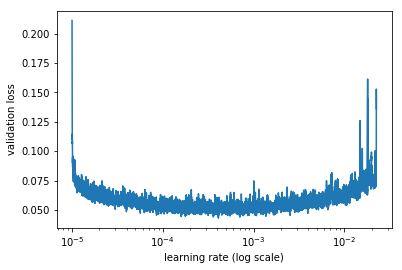

In [68]:
m.sched.plot(100)

In [50]:
lr = (1e-4 + 1e-5)/10*2
#lr = (1e-2 + 1e-3)/2

In [ ]:
m.fit(lr, 1, metrics=[exp_rmspe,mse])

In [52]:
m.fit(lr, 3, metrics=[exp_rmspe,mse])

epoch      trn_loss   val_loss   exp_rmspe  mse                     
    0      0.0465     0.047091   0.498072   3.248598  
    1      0.04442    0.045913   0.508785   3.129166                
    2      0.042198   0.04572    0.484184   3.139311                


[array([0.04572]), 0.48418407089880733, 3.1393110068751535]

In [53]:
m.fit(lr, 2, metrics=[exp_rmspe,mse], cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   exp_rmspe  mse                     
    0      0.044628   0.044828   0.502885   3.075001  
    1      0.047165   0.045007   0.525307   3.093218                
    2      0.046639   0.044543   0.507563   3.061406                


[array([0.04454]), 0.5075630787209192, 3.0614062441438055]

In [54]:
m.fit(lr, 2, metrics=[exp_rmspe,mse], cycle_len=2, cycle_mult=3)

epoch      trn_loss   val_loss   exp_rmspe  mse                     
    0      0.04369    0.044608   0.525943   3.072875  
    1      0.046419   0.044369   0.508905   3.057162                
    2      0.042602   0.044873   0.493378   3.115703                
    3      0.04245    0.044576   0.535748   3.070819                
    4      0.042642   0.044327   0.503734   3.061998                
    5      0.045447   0.044105   0.50002    3.057297                
    6      0.045845   0.043979   0.502742   3.050201                
    7      0.043472   0.043947   0.509785   3.03805                 


[array([0.04395]), 0.5097847675410806, 3.0380501450656396]

In [55]:
#m.fit(lr, 2, metrics=[exp_rmspe,mse], cycle_len=1, cycle_mult=2)

In [56]:
def output_submission(raw_test, prediction, id_column, prediction_column, file_name):
    df = pd.DataFrame(prediction, columns=[prediction_column])
    df[id_column] = raw_test[id_column]
    df[[id_column, prediction_column]].to_csv((file_name), index=False)
    print('Output complete')

In [57]:
m.save('val18')

In [58]:
m.load('val18')

In [59]:
x,y=m.predict_with_targs()

In [60]:
exp_rmspe(x,y)

9.251943847960833

In [61]:
pred_test=m.predict(True)

In [62]:
pred_test = np.exp(pred_test)

In [63]:
output_submission(df_test, pred_test, 'key', 'fare_amount', SUBMISSION_NAME)

Output complete
